In [1]:
import sys
sys.path.append('../')
import re
import os
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
import json
from utils.rouge import RougeL
from utils.precision_recall_f1 import precision_recall_f1
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
matplotlib.style.use('ggplot')

In [4]:
train_df = pd.read_csv('../input/original/train_round_0.csv')

In [6]:
train_df.head(1)

,answer,bridging_entity,content1,content2,content3,content4,content5,keyword,question,supporting_paragraph,title1,title2,title3,title4,title5,question_id
0,@content5@卡尔文森号航母@content5@,无,据美国媒体9月10日报道称，近日部署在美国东海岸多个军事基地的3艘核动力航母出现了罕见的一幕...,艾森豪威尔号航空母舰。它是美国尼米兹级核动力航空母舰的二号舰，舰名承袭自参加过第二次世界大战...,自2016年以来，美国海军第一次出现两艘核动力航母齐聚地中海的特殊部署，这意味着美国准备对某...,伊朗塔斯尼姆通讯社日前在社交媒体上发布了一段视频，视频中显示一艘航母在驱逐舰的护航下正在海面...,作为全世界唯一的超级大国，美国拥有10艘尼米兹核动力航母，其航母舰队和海军实力足以能够秒杀任...,“艾森豪威尔”号核动力航母,参与美韩举行的“鹞鹰”联合军演的是哪艘航母？,@content5@如今抵达西太平洋的美卡尔文森号航母，已经在该地区执行了一个多月的任务，并...,美军3艘核动力航母紧急机动，情况十分突然 高官：差点出了大事！,世界上最先进的航空母舰：艾森豪威尔号航空母舰！,局势十分紧张，美军两艘超级航母坐镇地中海 在向谁发出警告？,美航母抵近伊朗，伊战机紧急起飞，传回现场画面：甲板满是战机,美法曾联手包围俄航母 如今四国又来给中国添堵,Q_05193ghdyd


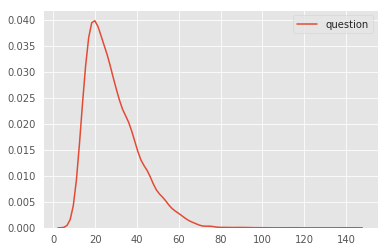

In [11]:
sns.kdeplot(train_df['question'].str.len())

In [7]:
questions = train_df['question']

In [31]:
TYPE_LIST = [
    'who', 'what', 'where', 'when', 'why', 'how',
    'count', 'topic', 'source',
    'others'
]
TYPE_DICT = {}
for type in TYPE_LIST:
    TYPE_DICT[type] = len(TYPE_DICT)

TYPE_KEYWORDS = {
    'who': ['谁', '什么人', '哪个发言人'],
    'what': ['哪', '什么'],
    'where': ['地点', '何地', '哪里', '何处', '哪片'],
    'when': ['时间', '何时', '何日', '时候'],
    'why': ['缘何', '为何'],
    'how': ['如何', '怎么', '怎样'],

    'count': ['多少', '几', '多久'],
    'topic': ['主旨', '大意', '内容', '态度', '目的', '文章说了什么', '介绍了什么'],
    'source': ['源自', '来源', '作者是'],

    # hidden -- 'others':[]
}


class QuestionTypeHandler(object):
    def __init__(self):
        self.type_count = len(TYPE_LIST)
        pass

    def ana_type(self, question):
        matched_types = []
        for type in TYPE_KEYWORDS:
            for keyword in TYPE_KEYWORDS[type]:
                if question.find(keyword) >= 0:
                    matched_types.append(type)
                    break
        if len(matched_types) == 0:
            matched_types.append('others')

        if len(matched_types) > 1:
            matched_types = [type for type in matched_types if type != 'what']
        
        type_vec = np.zeros([self.type_count], dtype=np.float32)
        for type in matched_types:
            type_vec[self.get_type_id(type)] = 1.0

        return matched_types, type_vec

    def get_type_id(self, type):
        # assert type in TYPE_DICT  # 默认一定在TypeDict里面
        return TYPE_DICT[type]


In [35]:
handler = QuestionTypeHandler()
question = '如何啊?'

print(handler.ana_type(question))

(['how'], array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32))


In [38]:
train_df['question_type'] = train_df['question'].map(lambda q: handler.ana_type(q)[0])

In [39]:
train_df[['question', 'question_type']]

,question,question_type
0,参与美韩举行的“鹞鹰”联合军演的是哪艘航母？,[what]
1,中菲关系焕发新的活力的好处是什么,[what]
2,海战开始，泰国海军一共损失了三艘什么艇？,[what]
3,"苏联把沙俄的""拉扎列夫海军上将""号改造后的重巡洋舰有多重？",[others]
4,AW－159 “野猫”直升机的机长是多少米？,[count]
5,哪款手枪代替了鲁格P-08成为了德军的制式手枪？,[what]
6,韩国空军现役主力战斗机是哪个？,[what]
7,法国政界对法国总统的什么行为感到抵触？,[what]
8,桑普森具有什么能力？,[what]
9,中越两国的“双料将军”是谁？,[who]


In [40]:
class QuestionTypeHandler2(object):
    def __init__(self):
        pattern_who = re.compile('什么人|谁')
        pattern_long = re.compile('多久|多长时间')
        pattern_how = re.compile('怎样|如何|怎么')
        pattern_when = re.compile('何时|什么时候|哪[\s\S]{0,3}(秒|分钟|小时|天|星期|月|年|世纪|期)|时间$')
        pattern_num = re.compile(
            '多少|多高|多远|多重|多大|多长|几|费用|比例|通过率|额度|手续费|速度|电话|金额|价格|税费|分数线|概率|尺寸')
        pattern_where = re.compile('哪里|在哪|什么[\s\S]*?地方|到哪|去哪|从哪')
        pattern_why = re.compile('为什么|为啥|什么原因|由来|原因')
        pattern_what = re.compile('什么|哪[个|些|种|集|国|家|艘|款]')
        pattern_rank = re.compile(
            '排名|排行|前[二|三|四|五|六|七|八|九|十]|[二|三|四|五|六|七|八|九|十]大')
        pattern_diff = re.compile('区别|不同|差异|差别')
        pattern_solution = re.compile('方法|办法|做法|算法|流程|技巧|攻略|规则|操作|规律|原理')
        pattern_result = re.compile('作用|影响|功效|疗效|后果|功能')
        self.pattern_list = [pattern_who, pattern_long, pattern_how, pattern_when, pattern_num, pattern_where,
                             pattern_why, pattern_what, pattern_rank, pattern_diff, pattern_solution, pattern_result]
        self.pattern_names = ['who', 'long', 'how', 'when', 'num',
                              'where', 'why', 'what', 'rank', 'diff', 'solution', 'result']
        assert len(self.pattern_list) == len(self.pattern_names)
        self.label_distrib = [0] * (len(self.pattern_list) + 1)

    def get_classify_label(self, text):
        """
        返回text对应的label_id以及label_name
        """
        for pid, (pattern, name) in enumerate(zip(self.pattern_list, self.pattern_names)):
            if re.findall(pattern, text):
                self.label_distrib[pid] += 1
                return pid, name
        # 未匹配
        self.label_distrib[-1] += 1
        return len(self.pattern_list), 'unk'

    def show_distrib(self):
        """
        打印各个标签的分布情况
        """
        all_cnt = sum(self.label_distrib)
        if all_cnt == 0:
            print('all fine classify label is zero!')
            return
        for name, cnt in zip(self.pattern_names + ['unk'], self.label_distrib):
            print('{}: {} -> {}'.format(name, cnt, cnt / all_cnt))


In [42]:
handler = QuestionTypeHandler2()
train_df['question_type2'] = train_df['question'].map(lambda q: handler.get_classify_label(q)[1])

In [43]:
train_df[['question', 'question_type2']]

,question,question_type2
0,参与美韩举行的“鹞鹰”联合军演的是哪艘航母？,unk
1,中菲关系焕发新的活力的好处是什么,what
2,海战开始，泰国海军一共损失了三艘什么艇？,what
3,"苏联把沙俄的""拉扎列夫海军上将""号改造后的重巡洋舰有多重？",num
4,AW－159 “野猫”直升机的机长是多少米？,num
5,哪款手枪代替了鲁格P-08成为了德军的制式手枪？,unk
6,韩国空军现役主力战斗机是哪个？,what
7,法国政界对法国总统的什么行为感到抵触？,what
8,桑普森具有什么能力？,what
9,中越两国的“双料将军”是谁？,who


In [66]:
train_df['question_pattetn'] = train_df['question'].map(lambda x: '因素' in x)

In [67]:
train_df[train_df['question_pattetn'] == True]['question']

3844                        叙利亚战事升级，导致叙利亚政府军苦不堪言的三个因素是？
9173                             德国空军由鼎盛到衰落的过程是什么因素造成的？
11188                       美国为什么成为了全球经济复苏的最大不确定因素和风险源？
11322                               维持中澳关系稳定的两个必要因素是什么？
14341                           南共体吸引中国企业到当地投资建厂的重要因素是？
21928            歼20的语音系统收录了全国多少种方言？歼-20击落敌机的最重要因素在于什么？
23848    俄罗斯计划用来替换其现役的T-72系列和T-80系列坦克的型号交付缓慢的主要因素可能是什么？
Name: question, dtype: object